Question 1
MLE Estimate for GD0.01
Test Accuracy Ratio for GD: 0.7333333333333333
Test Neg Log-likelihood for GD: [6.9744638]
MLE Estimate for SGD0.01
Test Accuracy Ratio for SGD: 0.7333333333333333
Test Neg Log-likelihood for SGD: [8.24550039]


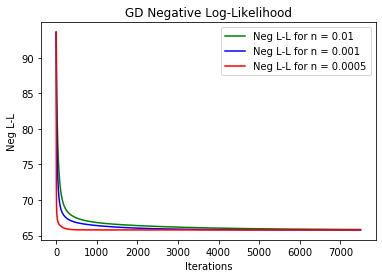

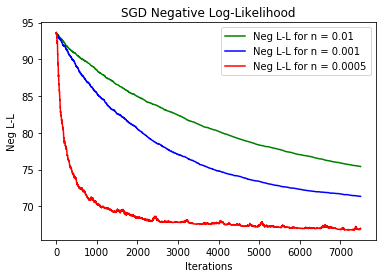

In [98]:
#Q1 imports
import numpy as np
import math
from matplotlib import pyplot as plt
from data_utils import load_dataset
import time
import random

#Q2 imports
import autograd.numpy as np
from autograd import value_and_grad
import matplotlib.pyplot as plt
from data_utils import plot_digit


#log likelihood Q1
def LL(estimates, actual):
    accum = 0
    for i in range(len(estimates)):
        accum += actual[i]*np.log(sigmoid(estimates[i])) + (1-actual[i])*np.log(1 - sigmoid(estimates[i]))
    return accum

# Error function root mean square
def rms_err(y_t, y_e):
    return np.sqrt(np.average((y_t-y_e)**2))

#euclidean distance
def l2norm(x1, x2):
    return np.linalg.norm([x1-x2], ord=2)

#accuracy ratio
def acc_ratio(y_test, y_estimates):
    return (y_estimates == y_test).sum() / len(y_test)

#sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#return accuracy ratio for Q2 classification
def acc_ratio2(prediction,actual):
    #set true and false
    for i in prediction:
        i[np.argmax(i,axis=0)]=True
        i[0:np.argmax(i,axis=0)]=False
        i[np.argmax(i,axis=0)+1:len(i)]=False
    accum=0
    for i in range(0,np.shape(prediction)[0]):
        if np.array_equal(prediction[i],actual[i]):
            accum+=1
    return accum/len(prediction)


#Question 1 **************************************************************************

def Q1f(x_train, x_valid, x_test, y_train, y_valid, y_test, rates, model):

    times = list() 
    test_ratio = list()
    test_logs = list()
    loss = {}
    x_train = np.vstack([x_train, x_valid])
    y_train = np.vstack([y_train, y_valid])

    #X and Xtest matrices
    X = np.ones((len(x_train), len(x_train[0]) + 1))
    X[:, 1:] = x_train
    X_test = np.ones((len(x_test), len(x_test[0]) + 1))
    X_test[:, 1:] = x_test

    j=0
    while j < len(rates):
        
        r=rates[j]
        w = np.zeros(np.shape(X[0, :])) #weights
        loss[r] = list()

        #gradient descent
        for i in range(7500):  #choose 5000 iterations

            est = np.dot(X, w)
            est = est.reshape(np.shape(y_train))
            #SGD
            if model == 'SGD':  
                i = random.randint(0, len(y_train)-1)
                grad = (y_train[i] - sigmoid(est[i])) * X[i, :]
            #GD
            elif model == 'GD':
                grad = np.zeros(np.shape(w))
                for i in range(len(y_train)):
                    grad += (y_train[i] - sigmoid(est[i])) * X[i, :]
            
            #new weights
            w = np.add(w, r*grad)
            #full batch LL
            L = LL(est, y_train)
            loss[r].append(-L)
        pred = np.zeros(np.shape(y_test))
        test_est = np.dot(X_test, w)
        test_est = test_est.reshape(np.shape(y_test))
        
        for i in range(len(pred)):
            p = sigmoid(test_est[i])
            if p > 1/2:
                pred[i] = 1
            elif p < 1/2:
                pred[i] = 0
            else:
                pred[i] = -1

        test_ratio.append(acc_ratio(y_test, pred))
        test_logs.append(LL(test_est, y_test))
        j+=1  
    tr = max(test_ratio)
    test_log = min(test_logs)
    return loss, tr, test_log


def plot(loss, model):

    x = list(range(7500))
    
    if model == 'GD':
        plt.figure(1)
        plt.title('GD Negative Log-Likelihood')
        plt.xlabel('Iterations')
        plt.ylabel('Neg L-L')
        j=0
        for i in loss:
            if j ==0:
                plt.plot(x, loss[i],'-g', label='Neg L-L for n = 0.01' )
                j+=1
            elif j ==1:
                plt.plot(x, loss[i],'-b', label='Neg L-L for n = 0.001' )
                j+=1
            else:
                plt.plot(x, loss[i],'-r', label='Neg L-L for n = 0.0005' )
            
        plt.legend(loc='upper right')


    elif model == 'SGD':
        plt.figure(2)
        plt.title('SGD Negative Log-Likelihood')
        plt.xlabel('Iterations')
        plt.ylabel('Neg L-L')
        j=0
        for i in loss:
            if j ==0:
                plt.plot(x, loss[i],'-g', label='Neg L-L for n = 0.01')
                j+=1
            elif j ==1:
                plt.plot(x, loss[i],'-b', label='Neg L-L for n = 0.001')
                j+=1
            else:
                plt.plot(x, loss[i],'-r', label='Neg L-L for n = 0.0005')
            
        plt.legend(loc='upper right')
        
        
#Question 2 ************************************************************************

def plot_digit(x, i):
    plt.figure(3+i)
    plt.imshow(x.reshape((28, 28)), interpolation='none', aspect='equal', cmap='gray')
    
def forward_pass(X,W1,W2,W3,b1,b2,b3):
    H1=np.maximum(0, np.dot(X, W1.T) + b1.T) 
    H2=np.maximum(0, np.dot(H1, W2.T) + b2.T)
    Fhat=np.dot(H2, W3.T) + b3.T 
    #stable log soft-max function 
    b=(np.amax(Fhat,axis=1)).reshape(len(X),1)
    f=b+(np.log(np.sum(np.exp(Fhat-b),axis=1))).reshape(len(X),1)
    lsm=Fhat-f
    return lsm

def negative_log_likelihood(X,W1,W2,W3,b1,b2,b3,Y):
    prediction=forward_pass(X,W1, W2, W3, b1, b2, b3)
    return -np.sum(np.multiply(prediction,Y))

def run_sgd(xtrain,xvalid,xtest,ytrain,yvalid,ytest):
    #compute gradient
    gradient=value_and_grad(negative_log_likelihood,argnum=[1,2,3,4,5,6])
    #weights initialized
    w1 = np.random.randn(100,784)/np.sqrt(784)
    w2 = np.random.randn(100,100)/np.sqrt(784)
    w3 = np.random.randn(10,100)/np.sqrt(784)
    #bias=0 initially
    B1 = np.zeros((100,1)) 
    B2 = np.zeros((100,1)) 
    B3 = np.zeros((10,1)) 
    negll=[]
    ivals=[]
    valid_negll=[]
    
    #iterations 7500
    i=0
    while i < 7500:
        #compute gradients
        if((250*(i+1))%10000==0):
            (loss, (W1grad, W2grad, W3grad, b1grad, b2grad, b3grad))=gradient(xtrain[(250*i)%10000:10000], w1, w2, w3, B1, B2, B3,ytrain[(250*i)%10000:10000]) #use correct portion of sets
        else:
            (loss, (W1grad, W2grad, W3grad, b1grad, b2grad, b3grad))=gradient(xtrain[(250*i)%10000:(250*(i+1))%10000],w1, w2, w3, B1, B2, B3,ytrain[(250*i)%10000:(250*(i+1))%10000]) #use correct portion of sets
        #update lists
        valid_negll.append(negative_log_likelihood(xvalid,w1,w2,w3,B1,B2,B3,yvalid))
        negll.append(loss)
        ivals.append(i)
        #update weights
        w1=w1-0.0005*W1grad
        w2=w2-0.0005*W2grad
        w3=w3-0.0005*W3grad
        B1=B1-0.0005*b1grad
        B2=B2-0.0005*b2grad
        B3=B3-0.0005*b3grad
        i+=1
           
    return ivals,losses,val_losses

#MAIN

Q1 = True   #SET TRUE TO SHOW ANSWER

Q2 = False    #SET TRUE TO SHOW ANSWER

if __name__ == '__main__':
    all_datas = ['mauna_loa', 'rosenbrock', 'pumadyn32nm', 'iris', 'mnist_small']    

if Q1:
    
    print('Question 1')

    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
    
    y_train, y_valid, y_test = y_train[:, (1,)], y_valid[:, (1,)], y_test[:, (1,)]
    y_train = np.asarray(y_train, int)  #convert
    y_valid = np.asarray(y_valid, int)  #convert
    y_test = np.asarray(y_test, int)     #convert
        
    r1 = [0.0005, 0.001, 0.01]
    ll_gd, ratio_gd, test_ll_gd = Q1f(x_train, x_valid, x_test, y_train, y_valid, y_test, r1, 'GD')
    plot(ll_gd, 'GD')

    r2 = [0.0005, 0.001, 0.01]
    ll_sgd, ratio_sgd, test_ll_sgd = Q1f(x_train, x_valid, x_test, y_train, y_valid, y_test, r2, 'SGD')
    plot(ll_sgd, 'SGD')
    #mlegd=max(ll_gd)
    #mlesgd=max(ll_sgd)
    

    print('MLE Estimate:  ' + str(mlegd))
    print('Test Accuracy Ratio for GD: ' + str(ratio_gd))
    print('Test Neg Log-likelihood for GD: ' + str(-1*test_ll_gd))
   # print('MLE Estimate for SGD' + str(mlesgd))
    print('Test Accuracy Ratio for SGD: ' + str(ratio_sgd))
    print('Test Neg Log-likelihood for SGD: ' + str(-1*test_ll_sgd))
    
if Q2:
    
    print('Question 2')
    print('')
    
    xtrain, xvalid, xtest, ytrain, yvalid, ytest = load_dataset('mnist_small')

    iters,ll,valid_ll=run_sgd(xtrain,xvalid,xtest,ytrain,yvalid,ytest)
    plt.plot(np.array(iters),np.array(ll),'-r',label='Training Set')
    plt.plot(np.array(iters),np.array(valid_ll),'-g',label='Validation Set')
    plt.title('Neg Log-Likelihood vs Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Neg Log-Likelihood')
    plt.legend(loc='upper right')
    
    prediction=forward_pass(xtest,w1, w2, w3, B1, B2, B3)
    rat = acc_ratio2(prediction,ytest)
    print('Test Accuracy Ratio for NN: ' + str(rat))  
    
    #Q2d, plot some values that have a low confidence
    prediction=forward_pass(xtest,w1, w2, w3, B1, B2, B3)
    idx=[]
    for i in range(0,len(prediction)):
        if(prediction[i][np.argmax(prediction[i],axis=0)]<-0.3 ): #lower than log(50%) confidence
            idx=idx+[(i,np.exp(np.amax(prediction[i],axis=0)))]
    for i in range(len(idx)):
        j=idx[i][0]
        x=xtest[j]
        plot_digit(x, i)
    